In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import io
import re
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy.interpolate import make_interp_spline

# Configuration options
SMOOTH_CONFIDENCE_INTERVALS = True  # Set to False for original stepped confidence intervals
SMOOTHING_POINTS = 100  # Number of points for interpolation (higher = smoother)
SHOW_INDIVIDUAL_SAMPLES = False  # Show individual sample trajectories
SHOW_AGGREGATED = True  # Show aggregated trajectories by sample type
SHOW_50_CONFIDENCE = True
SHOW_95_CONFIDENCE = False

df = pd.read_csv('Cyano Lysate - K. Rhaeticus Feedstock Combined.csv', sep=',', comment='>')
df

,Media,Sample,Day 0 Replicate #1,Day 0 Replicate #2,Day 1 Replicate #1,Day 1 Replicate #2,Day 2 Replicate #1,Day 2 Replicate #2,Day 3 Replicate #1,Day 3 Replicate #2,Day 4 Replicate #1,Day 4 Replicate #2,Day 5 Replicate #1,Day 5 Replicate #2,Day 6 Replicate #1,Day 6 Replicate #2
0,No Glucose,No Cyano 1,0.046,0.042,0.043,0.050,0.050,0.049,0.054,0.055,0.068,0.068,NaN,NaN,NaN,NaN
1,No Glucose,Filtered Cyano 1,0.043,0.044,0.044,0.043,0.044,0.043,0.177,0.148,0.197,0.235,NaN,NaN,NaN,NaN
2,No Glucose,No Cyano 2,0.055,NaN,0.041,0.047,0.041,0.048,0.048,0.051,0.053,0.055,0.055,0.054,0.060,0.057
3,No Glucose,No Cyano 3,0.043,NaN,0.040,0.047,0.042,0.043,0.048,0.048,0.053,0.050,0.053,0.052,0.054,0.056
4,No Glucose,No Cyano 4,0.042,NaN,0.040,0.047,0.043,0.043,0.048,0.049,0.053,0.055,0.052,0.054,0.055,0.057
5,No Glucose,Filtered Cyano 2,0.042,NaN,0.041,0.042,0.115,0.119,0.151,0.164,0.108,0.111,0.105,0.101,0.108,0.113
6,No Glucose,Filtered Cyano 3,0.040,NaN,0.042,0.042,0.044,0.064,0.171,0.177,0.120,0.123,0.100,0.110,0.097,0.098
7,No Glucose,Filtered Cyano 4,NaN,NaN,0.046,0.046,0.066,0.068,0.107,0.112,0.110,0.111,0.087,0.091,0.092,0.094
8,No Glucose,Filtered Cyano 5,NaN,NaN,0.096,0.109,0.088,0.071,0.058,0.076,0.049,0.058,0.040,0.036,0.052,0.050
9,No Glucose,Filtered Cyano 6,NaN,NaN,0.049,0.049,0.065,0.071,0.080,0.088,0.095,0.106,0.076,0.077,0.086,0.087


Data shape after cleaning: (242, 6)
Day range: 0 to 6
Unique samples: ['No Cyano 1' 'Filtered Cyano 1' 'No Cyano 2' 'No Cyano 3' 'No Cyano 4'
 'Filtered Cyano 2' 'Filtered Cyano 3' 'No Cyano 5' 'No Cyano 6'
 'No Cyano 7' 'Filtered Cyano 4' 'Filtered Cyano 5' 'Filtered Cyano 6']
Sample types found: ['No Cyano' 'Filtered Cyano']
Combined groups: ['No Glucose + No Cyano' 'No Glucose + Filtered Cyano'
 'Regular HS + No Cyano']

Sample Summary DataFrame shape: (125, 7)
Sample Summary DataFrame (first 10 rows):
             Sample       Media     Sample_Type  X_Axis_Time_Days  OD_mean  \
0  Filtered Cyano 1  No Glucose  Filtered Cyano                 0   0.0435   
1  Filtered Cyano 1  No Glucose  Filtered Cyano                 1   0.0435   
2  Filtered Cyano 1  No Glucose  Filtered Cyano                 2   0.0435   
3  Filtered Cyano 1  No Glucose  Filtered Cyano                 3   0.1625   
4  Filtered Cyano 1  No Glucose  Filtered Cyano                 4   0.2160   
5  Filtered Cyano 2  

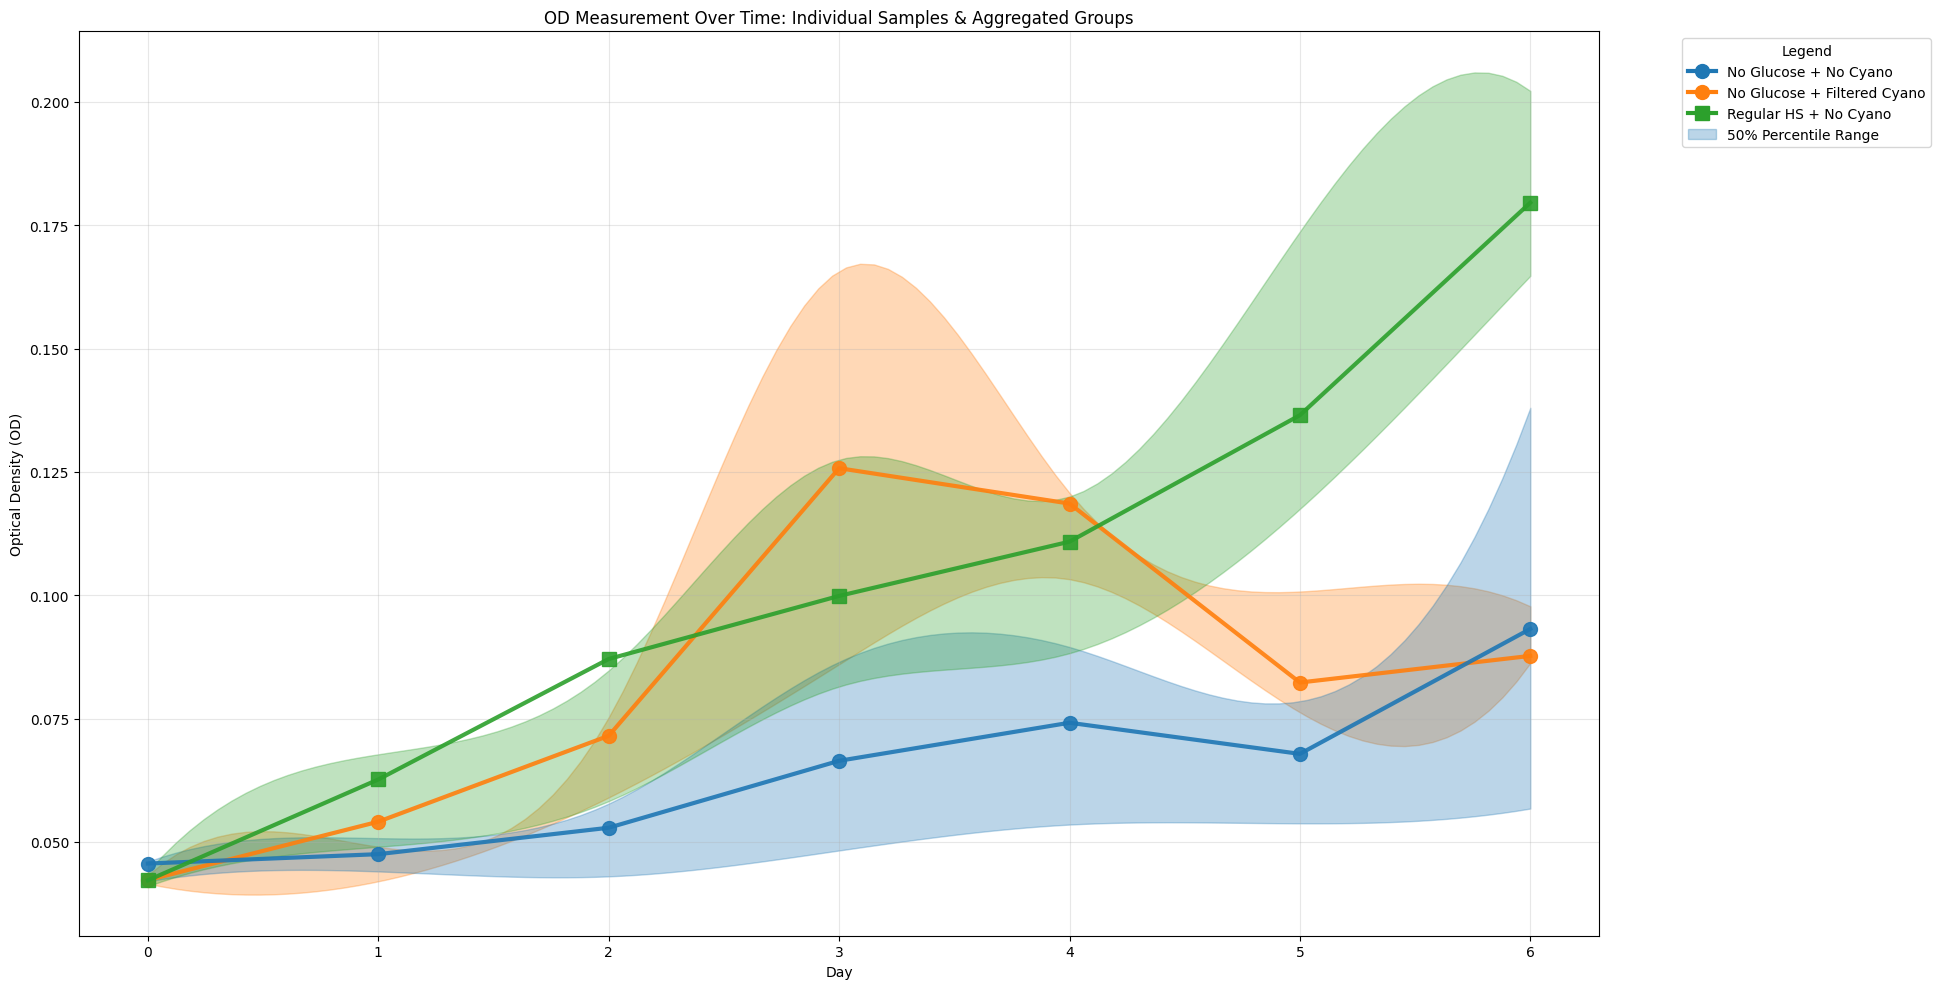

In [5]:

# 2. Reshape Data
df_melted = df.melt(id_vars=['Media', 'Sample'], var_name='Day_Replicate', value_name='OD')

# 3. Parse 'Day_Replicate' column to extract day number and replicate
def parse_day_replicate(day_replicate_str):
    if pd.isna(day_replicate_str): 
        return None, None
    # Match pattern like "Day 0 Replicate #1", "Day 10 Replicate #2", etc.
    match = re.match(r'Day\s+(\d+)\s+Replicate\s+#(\d+)', day_replicate_str)
    if match:
        day_num, replicate_num = match.group(1), match.group(2)
        try:
            return int(day_num), int(replicate_num)
        except ValueError: 
            return None, None
    return None, None

df_melted[['Day', 'Technical_Replicate']] = df_melted['Day_Replicate'].apply(lambda x: pd.Series(parse_day_replicate(x)))

# Remove rows with missing data (NaN values, empty strings, or failed parsing)
df_melted = df_melted.dropna(subset=['Day', 'OD'])
df_melted['OD'] = pd.to_numeric(df_melted['OD'], errors='coerce')
df_melted = df_melted.dropna(subset=['OD'])

print(f"Data shape after cleaning: {df_melted.shape}")
print(f"Day range: {df_melted['Day'].min()} to {df_melted['Day'].max()}")
print(f"Unique samples: {df_melted['Sample'].unique()}")

# 4. Define sample types by extracting meaningful categories from sample names
def extract_sample_type(sample_name):
    sample_name = sample_name.lower()
    if 'filtered cyano' in sample_name and 'unfiltered' not in sample_name:
        return 'Filtered Cyano'
    elif 'unfiltered cyano' in sample_name:
        return 'Unfiltered Cyano'
    elif 'no cyano' in sample_name:
        return 'No Cyano'
    else:
        return 'Other'

df_melted['Sample_Type'] = df_melted['Sample'].apply(extract_sample_type)
# Create a combined group identifier
df_melted['Combined_Group'] = df_melted['Media'] + ' + ' + df_melted['Sample_Type']

print(f"Sample types found: {df_melted['Sample_Type'].unique()}")
print(f"Combined groups: {df_melted['Combined_Group'].unique()}")

# 5. Use Day as the X-axis (no time conversion needed)
df_melted['X_Axis_Time_Days'] = df_melted['Day']

# 6. Prepare data for individual samples and aggregated groups

# First, calculate statistics across technical replicates for each sample
sample_agg_funcs = {
    'OD_mean': ('OD', 'mean'),
    'OD_std': ('OD', 'std'),  # Standard deviation across technical replicates
    'OD_count': ('OD', 'count')  # Number of replicates
}
df_sample_summary = df_melted.groupby(['Sample', 'Media', 'Sample_Type', 'X_Axis_Time_Days']).agg(**sample_agg_funcs).reset_index()

# Handle cases where there's only one replicate (std will be NaN)
df_sample_summary['OD_std'] = df_sample_summary['OD_std'].fillna(0)

print(f"\nSample Summary DataFrame shape: {df_sample_summary.shape}")
print("Sample Summary DataFrame (first 10 rows):")
print(df_sample_summary.head(10))

# Then aggregate by Combined_Group for the grouped visualization
group_agg_funcs = {
    'OD_mean': ('OD', 'mean'),
    'OD_std': ('OD', 'std'),
    'OD_p025': ('OD', lambda x: np.percentile(x, 2.5) if len(x) > 1 else x.iloc[0]),
    'OD_p975': ('OD', lambda x: np.percentile(x, 97.5) if len(x) > 1 else x.iloc[0]),
    'OD_p25': ('OD', lambda x: np.percentile(x, 25) if len(x) > 1 else x.iloc[0]),
    'OD_p75': ('OD', lambda x: np.percentile(x, 75) if len(x) > 1 else x.iloc[0]),
    'OD_count': ('OD', 'count')
}
df_group_summary = df_melted.groupby(['Combined_Group', 'Media', 'Sample_Type', 'X_Axis_Time_Days']).agg(**group_agg_funcs).reset_index()

print(f"\nGroup Summary DataFrame shape: {df_group_summary.shape}")
print("Group Summary DataFrame (first 10 rows):")
print(df_group_summary.head(10))

# 7. Plotting
plt.figure(figsize=(24, 10))

# Create color maps for both sample types and individual samples
group_types = df_melted['Combined_Group'].unique()
group_palette = sns.color_palette("tab10", n_colors=len(group_types))
group_color_map = dict(zip(group_types, group_palette))

samples = df_melted['Sample'].unique()
# Use a color palette that's related to the group colors but with variations
sample_palette = []
for group in group_types:
    sample_type = group.split(' + ')[1]
    group_samples = [s for s in samples if extract_sample_type(s) == sample_type]
    # For each group, create slightly varied shades of the group color
    base_color = group_color_map[group]
    for i, sample in enumerate(group_samples):
        # Slightly modify the base color for each sample
        variation = (i - len(group_samples)//2) * 0.1  # Center the variations around the base color
        modified_color = [
            max(0, min(1, base_color[0] + variation)),
            max(0, min(1, base_color[1] + variation)),
            max(0, min(1, base_color[2] + variation))
        ]
        sample_palette.append((sample, modified_color))

# Create a mapping from sample to color
sample_color_map = dict(sample_palette)

# Create a mapping for Media to Matplotlib markers
unique_media_types = df_melted['Media'].unique()
available_markers = ['o', 's', '^', 'P', '*', 'X', 'D', 'v', '<', '>']
marker_map = {media: available_markers[i % len(available_markers)] for i, media in enumerate(unique_media_types)}

# Function to create smooth interpolated lines
def create_smooth_line(x, y, num_points=SMOOTHING_POINTS):
    # Only interpolate if we have enough points and user wants smoothing
    if len(x) > 2 and SMOOTH_CONFIDENCE_INTERVALS:
        # Create a smooth spline interpolation
        x_new = np.linspace(min(x), max(x), num_points)
        try:
            spl = make_interp_spline(x, y, k=min(3, len(x)-1))  # k is the degree of spline
            y_new = spl(x_new)
            return x_new, y_new
        except Exception as e:
            print(f"Interpolation error: {e}. Falling back to original data.")
            return x, y
    return x, y

# Plot individual sample trajectories if enabled
if SHOW_INDIVIDUAL_SAMPLES:
    for sample_name, sample_data in df_sample_summary.groupby('Sample'):
        sample_data = sample_data.sort_values('X_Axis_Time_Days')
        
        # Get the combined group for this sample to determine base color
        sample_type = sample_data['Sample_Type'].iloc[0]
        media = sample_data['Media'].iloc[0]
        combined_group = f"{media} + {sample_type}"
        
        # Use sample-specific color if available, otherwise fall back to group color
        color = sample_color_map.get(sample_name, group_color_map.get(combined_group, 'gray'))
        
        x_values = sample_data['X_Axis_Time_Days'].values
        y_values = sample_data['OD_mean'].values
        error = sample_data['OD_std'].values
        
        # Plot the individual sample line with error bars
        plt.errorbar(x_values, y_values, yerr=error, 
                  label=sample_name, color=color, 
                  marker=marker_map.get(media, 'o'),
                  markersize=6, linestyle='-', linewidth=1.5,
                  elinewidth=1.5, capsize=4, alpha=0.8)

# Plot aggregated group trajectories if enabled
if SHOW_AGGREGATED:
    for group_name, group_data in df_group_summary.groupby('Combined_Group'):
        group_data = group_data.sort_values('X_Axis_Time_Days')
        current_media = group_data['Media'].iloc[0]
        
        x_values = group_data['X_Axis_Time_Days'].values
        y_mean = group_data['OD_mean'].values
        
        # Plot with thicker line to distinguish from individual samples
        plt.plot(x_values, y_mean, 
                 label=f"{group_name} (Aggregated)", color=group_color_map[group_name], 
                 marker=marker_map.get(current_media, 'o'),
                 markersize=10, linestyle='-', linewidth=3.0, alpha=0.9)
        
        # Create smooth confidence intervals if enabled
        if SMOOTH_CONFIDENCE_INTERVALS and len(x_values) > 1:
            # Only create confidence intervals if we have sufficient data points
            try:
                if SHOW_95_CONFIDENCE:
                    # 95% confidence interval
                    x_smooth, lower_95 = create_smooth_line(x_values, group_data['OD_p025'].values)
                    _, upper_95 = create_smooth_line(x_values, group_data['OD_p975'].values)
                    plt.fill_between(x_smooth, lower_95, upper_95,
                                    color=group_color_map[group_name], alpha=0.15, 
                                    label=f'{group_name} 95% range')
                if SHOW_50_CONFIDENCE:
                    # 50% confidence interval
                    x_smooth, lower_50 = create_smooth_line(x_values, group_data['OD_p25'].values)
                    _, upper_50 = create_smooth_line(x_values, group_data['OD_p75'].values)
                    plt.fill_between(x_smooth, lower_50, upper_50,
                                    color=group_color_map[group_name], alpha=0.3, 
                                    label=f'{group_name} 50% range')
            except Exception as e:
                print(f"Error creating smooth confidence intervals for {group_name}: {e}")
                # Fall back to non-smooth intervals

                if SHOW_95_CONFIDENCE:
                    plt.fill_between(x_values, group_data['OD_p025'], group_data['OD_p975'],
                                color=group_color_map[group_name], alpha=0.15, 
                                label=f'{group_name} 95% range')
                if SHOW_50_CONFIDENCE:
                    plt.fill_between(x_values, group_data['OD_p25'], group_data['OD_p75'],
                                color=group_color_map[group_name], alpha=0.3, 
                                label=f'{group_name} 50% range')
        elif len(x_values) > 1:  # Non-smooth confidence intervals
            if SHOW_95_CONFIDENCE:
                plt.fill_between(x_values, group_data['OD_p025'], group_data['OD_p975'],
                            color=group_color_map[group_name], alpha=0.15, 
                            label=f'{group_name} 95% range')
            if SHOW_50_CONFIDENCE:
                plt.fill_between(x_values, group_data['OD_p25'], group_data['OD_p75'],
                            color=group_color_map[group_name], alpha=0.3, 
                            label=f'{group_name} 50% range')

plt.title('OD Measurement Over Time: Individual Samples & Aggregated Groups')
plt.xlabel('Day')
plt.ylabel('Optical Density (OD)')

# Create custom legend with filtered elements to avoid overcrowding
legend_elements = []

# First, add individual samples if they're enabled
if SHOW_INDIVIDUAL_SAMPLES:
    for sample_name in samples:
        media = df_melted[df_melted['Sample'] == sample_name]['Media'].iloc[0]
        color = sample_color_map.get(sample_name, 'gray')
        marker = marker_map.get(media, 'o')
        # Create error bar representation for legend
        legend_elements.append(Line2D([0], [0], color=color, lw=1.5, marker=marker,
                                     markersize=6, label=sample_name))

# Then add aggregated groups if they're enabled
if SHOW_AGGREGATED:
    for group_name in group_types:
        media = df_melted[df_melted['Combined_Group'] == group_name]['Media'].iloc[0]
        color = group_color_map.get(group_name, 'gray')
        marker = marker_map.get(media, 'o')
        legend_elements.append(Line2D([0], [0], color=color, lw=3.0, marker=marker,
                                     markersize=10, label=f"{group_name}"))

# Finally add one example each of the range patches
if not df_group_summary.empty and SHOW_AGGREGATED:
    rep_color = group_color_map.get(group_types[0], 'gray') if len(group_types) > 0 else 'gray'
    if SHOW_50_CONFIDENCE:
        legend_elements.append(Patch(facecolor=rep_color, edgecolor=rep_color, alpha=0.3,
                                label='50% Percentile Range'))
    if SHOW_95_CONFIDENCE:
        legend_elements.append(Patch(facecolor=rep_color, edgecolor=rep_color, alpha=0.15,
                                label='95% Percentile Range'))

# Create the legend - put it outside the plot area
if len(legend_elements) > 8:
    plt.legend(handles=legend_elements, title='Legend', bbox_to_anchor=(1.05, 1), 
              loc='upper left', ncol=1, frameon=True, fontsize='small')
else:
    plt.legend(handles=legend_elements, title='Legend', bbox_to_anchor=(1.05, 1), 
              loc='upper left')

plt.grid(True, alpha=0.3)
plt.tight_layout(rect=[0, 0, 0.82, 1])  # Adjust rect for legend

# Add notes about configuration
# notes = []
# # notes.append(f"Confidence interval smoothing: {'ON' if SMOOTH_CONFIDENCE_INTERVALS else 'OFF'}")
# # notes.append(f"Individual samples: {'Shown' if SHOW_INDIVIDUAL_SAMPLES else 'Hidden'}")
# # notes.append(f"Aggregated groups: {'Shown' if SHOW_AGGREGATED else 'Hidden'}")
# # notes.append(f"Data points: Days {df_melted['Day'].min()}-{df_melted['Day'].max()}")
# note_text = "\n".join(notes)
# plt.figtext(0.01, 0.01, note_text, fontsize=8, style='italic')

# Determine filename based on configuration
filename_parts = ["od_plot"]
if SHOW_INDIVIDUAL_SAMPLES: filename_parts.append("individual")
if SHOW_AGGREGATED: filename_parts.append("aggregated")
if SMOOTH_CONFIDENCE_INTERVALS: filename_parts.append("smooth")
filename_parts.append("days")

plot_filename = f"{'_'.join(filename_parts)}.png"
plt.savefig(plot_filename, bbox_inches='tight', dpi=150)
print(f"\nPlot saved as {plot_filename}")

# Save processed data
processed_csv_path = 'processed_day_samples_and_groups_data.csv'
df_melted.to_csv(processed_csv_path, index=False)

# Save summary stats for both individual samples and groups
sample_summary_csv_path = 'summary_stats_individual_samples_days.csv'
df_sample_summary.to_csv(sample_summary_csv_path, index=False)

group_summary_csv_path = 'summary_stats_aggregated_groups_days.csv'
df_group_summary.to_csv(group_summary_csv_path, index=False)

print(f"\nProcessed data saved to {processed_csv_path}")
print(f"Individual sample statistics saved to {sample_summary_csv_path}")
print(f"Aggregated group statistics saved to {group_summary_csv_path}")

# Print summary statistics
print(f"\n=== DATA SUMMARY ===")
print(f"Total data points: {len(df_melted)}")
print(f"Samples: {len(samples)} ({', '.join(samples)})")
print(f"Sample types: {len(df_melted['Sample_Type'].unique())} ({', '.join(df_melted['Sample_Type'].unique())})")
print(f"Days covered: {df_melted['Day'].min()} to {df_melted['Day'].max()}")
print(f"Media types: {', '.join(df_melted['Media'].unique())}")